# Event data, `GammaObs` and `GammaObsCube`

There are many different file formats and storage methods for event data within gamma-ray astronomy, unfortunately I felt the need to make my own method to store this data. 

I can see how this may be a further complication to the time-poor researcher hence few classes must depend on this data structure but I do think it is handy and it is the default for most of the simulation classes within the pipeline.

## `GammaObs`

`GammaObs` is the base class for this information and is meant to store information about a single observation in a histogram-like data structure. It's behaviours mostly centre around using unique event values for use within the pipeline and then one can use the bin values as event weights within the hyperparameter likelihood during the final stage of inference.

It's easiest to explain what it does through examples so I'm going to generate some very fake event data first. I will use some of the things explained in previous tutorials (mainly through `GammaBinning`, `IRF_Loglikelihood` and `GammaLogExposure`).

In [1]:
from gammabayes import GammaBinning, GammaLogExposure
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
import numpy as np, os, sys
from scipy.stats import norm
from astropy import units as u
binning_geometry = GammaBinning(energy_axis=np.logspace(-1, 2, 121)*u.TeV, 
                                lon_axis=np.linspace(-5, 5, 101)*u.deg, 
                                lat_axis=np.linspace(-5, 5, 101)*u.deg)


pointing = np.array([0.,0.])*u.deg
observation_time = 0.5*u.hr
irf_loglike = IRF_LogLikelihood(binning_geometry=binning_geometry, 
                                true_binning_geometry=binning_geometry,
                                pointing_dir=pointing, observation_time=observation_time)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we'll simulate the data where the spatial event will be generated from a 2d normal distribution (with 0 covariance) centred at (0,0) and the energy distribution will follow a exponential distribution (no particular reason for either, just need some values to mess around with).

In [2]:
num_events = int(1e5)

energy_data = np.power(10., norm(scale=0.3).rvs(size=num_events))*u.TeV
lon_data = norm(scale=2).rvs(num_events)*u.deg
lat_data = norm(scale=0.3).rvs(num_events)*u.deg

First we will manually look at these values.

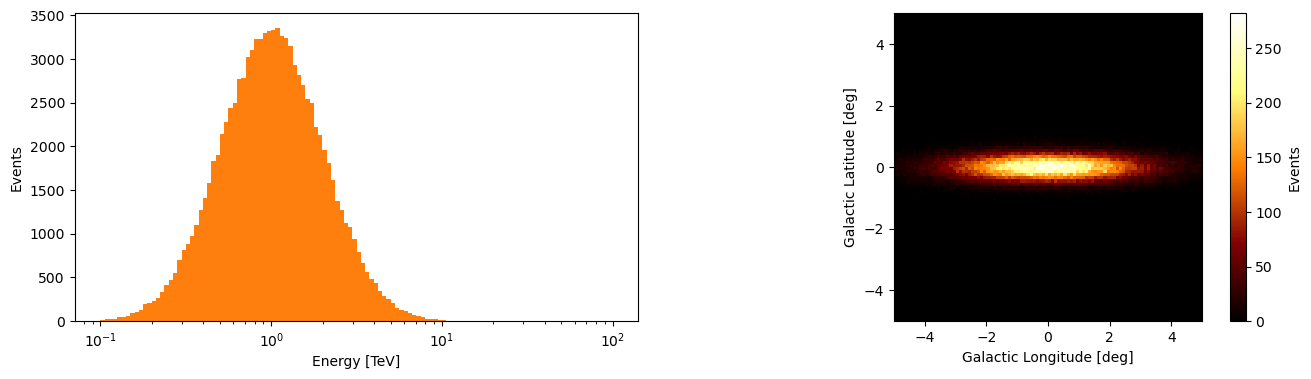

In [3]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16,4))

axs[0].hist(energy_data.value, bins=binning_geometry.energy_axis.value, color='tab:orange')
axs[0].set_xscale('log')
axs[0].set_xlabel('Energy [TeV]')
axs[0].set_ylabel('Events')

hist2d_thingy = axs[1].hist2d(x=lon_data.value, y=lat_data.value, 
              bins=[binning_geometry.lon_axis.value, binning_geometry.lat_axis.value],
              cmap='afmhot')
plt.colorbar(mappable=hist2d_thingy[3], label='Events', ax=axs[1])
axs[1].set_xlabel("Galactic Longitude [deg]")
axs[1].set_ylabel("Galactic Latitude [deg]")
axs[1].set_aspect('equal')

There are then a few things that we may wish to do with this data, but primarily for inference we want to know the probability of an event coming from a specific model with a set of parameters. 

Ideally we would perform this on the unique event values and store the number of times this combination of parameters is repeated (i.e. how many events have the same values) which is essentially the histogram above.

However there are two problems with this, we will have many observations to deal with and we need to know which set of unique event values come from what observation and we need to keep track of what set of event weights correspond to what set of unique values.

Additionally the analysis will depend on meta-data related to the observation like the pointing direction, observation time and the set of IRFs correspond to that observation run.

You can probably see what I made this class now.

In [4]:
from gammabayes import GammaObs


observation_data = GammaObs(energy=energy_data, lon=lon_data, lat=lat_data, 
                            binning_geometry=binning_geometry, 
                            irf_loglike=irf_loglike,
                            pointing_dir=pointing,
                            observation_time=observation_time,
                            meta={"true_event_data":True})

And like most of the data classes in `GammaBayes` there is a `peek` method to view this data.

array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

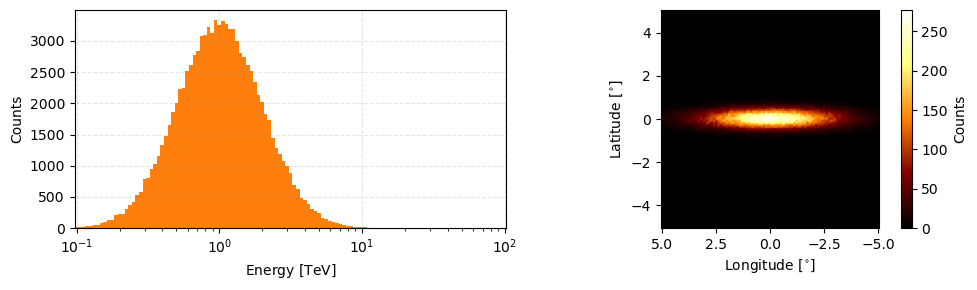

In [5]:
observation_data.peek(figsize=(10,3))

You directly access the stored values with the `energy`, `lon` and `lat` attributes.

In [6]:
observation_data.energy, observation_data.lon, observation_data.lat

(<Quantity [1.48215797, 1.41544139, 0.30692271, ..., 5.7067139 , 0.85388583,
            0.78240917] TeV>,
 <Quantity [-3.64454893, -0.08601721,  1.70710218, ..., -2.16771089,
             0.60079871, -2.51932362] deg>,
 <Quantity [ 0.21880036, -0.29531492,  0.47025976, ...,  0.23628938,
            -0.06557202,  0.20532111] deg>)

And all the other information are also available through the relevant attributes

In [7]:
observation_data.pointing_dir, observation_data.observation_time, '\n', observation_data.irf_loglike

(<Quantity [0., 0.] deg>,
 <Quantity 0.5 h>,
 '\n',
 discrete log likelihood class
 ---------------------------------
 name = ['None']
 logfunction type is <bound method IRFExtractor.single_loglikelihood of <gammabayes.likelihoods.irfs.irf_extractor_class.IRFExtractor object at 0x19c43f200>>
 input units of ['None'])

You can access the binned data through a couple methods

The `binned_data` contains a matrix of the event counts with no axis information (besides the shape of the matrix)

In [8]:
observation_data.binned_data.shape, np.sum(observation_data.binned_data)

((121, 101, 101), 98819.0)

This means that out of the 100,000 events there are `np.sum(observation_data.binned_data)` unique ones.

You can additionally access individual binned energy, longitude and latitude values through the `binned_energy`, `binned_lon` and `binned_lat` attributes.

In [9]:
observation_data.binned_energy

(array([1.500e+01, 1.800e+01, 2.100e+01, 2.700e+01, 4.100e+01, 5.000e+01,
        5.300e+01, 7.500e+01, 9.400e+01, 1.330e+02, 1.380e+02, 2.050e+02,
        2.280e+02, 2.330e+02, 3.030e+02, 3.730e+02, 4.240e+02, 5.230e+02,
        5.750e+02, 7.860e+02, 8.090e+02, 9.410e+02, 1.023e+03, 1.156e+03,
        1.340e+03, 1.477e+03, 1.652e+03, 1.857e+03, 2.004e+03, 2.223e+03,
        2.240e+03, 2.514e+03, 2.622e+03, 2.777e+03, 2.837e+03, 3.078e+03,
        3.091e+03, 3.229e+03, 3.125e+03, 3.330e+03, 3.249e+03, 3.326e+03,
        3.269e+03, 3.192e+03, 3.187e+03, 2.998e+03, 2.815e+03, 2.738e+03,
        2.610e+03, 2.516e+03, 2.343e+03, 2.131e+03, 2.021e+03, 1.833e+03,
        1.734e+03, 1.450e+03, 1.283e+03, 1.190e+03, 1.072e+03, 1.000e+03,
        8.820e+02, 6.990e+02, 6.320e+02, 4.830e+02, 4.570e+02, 3.890e+02,
        3.000e+02, 2.740e+02, 2.440e+02, 1.570e+02, 1.440e+02, 1.120e+02,
        1.060e+02, 8.900e+01, 6.300e+01, 4.900e+01, 3.100e+01, 2.800e+01,
        1.800e+01, 1.900e+01, 1.200e+0

So the output is a tuple where the first output are the bin counts and the second output are the corresponding energy values. The longitude and latitude attributes follow the same pattern.

If you want to extract an array of the unique parameter values and event counts/weights you can call `nonzero_bin_data`

In [10]:
observation_data.nonzero_bin_data

(array([[<Quantity 0.1 TeV>, <Quantity -2.3 deg>, <Quantity 0. deg>],
        [<Quantity 0.1 TeV>, <Quantity -2.1 deg>, <Quantity 0. deg>],
        [<Quantity 0.1 TeV>, <Quantity -1.5 deg>, <Quantity -0.3 deg>],
        ...,
        [<Quantity 14.12537545 TeV>, <Quantity 1.8 deg>,
         <Quantity 0.7 deg>],
        [<Quantity 15.84893192 TeV>, <Quantity -4.8 deg>,
         <Quantity -0.3 deg>],
        [<Quantity 22.38721139 TeV>, <Quantity -0.7 deg>,
         <Quantity -0.4 deg>]], dtype=object),
 array([1., 1., 1., ..., 1., 1., 1.]))

Where the first entry in the output is the coordinate values (energy, lon, lat) and the second entry would be the number of times for the coordinate values. And if you just want the unique coordinate values then you can calle `nonzero_coordinate_data`.

In [11]:
observation_data.nonzero_coordinate_data

array([[<Quantity 0.1 TeV>, <Quantity -2.3 deg>, <Quantity 0. deg>],
       [<Quantity 0.1 TeV>, <Quantity -2.1 deg>, <Quantity 0. deg>],
       [<Quantity 0.1 TeV>, <Quantity -1.5 deg>, <Quantity -0.3 deg>],
       ...,
       [<Quantity 14.12537545 TeV>, <Quantity 1.8 deg>,
        <Quantity 0.7 deg>],
       [<Quantity 15.84893192 TeV>, <Quantity -4.8 deg>,
        <Quantity -0.3 deg>],
       [<Quantity 22.38721139 TeV>, <Quantity -0.7 deg>,
        <Quantity -0.4 deg>]], dtype=object)

Additionally it has iterative behaviour that will loop through the unique coordinate data.

In [12]:
observation_data.nonzero_bin_data[0]


array([[<Quantity 0.1 TeV>, <Quantity -2.3 deg>, <Quantity 0. deg>],
       [<Quantity 0.1 TeV>, <Quantity -2.1 deg>, <Quantity 0. deg>],
       [<Quantity 0.1 TeV>, <Quantity -1.5 deg>, <Quantity -0.3 deg>],
       ...,
       [<Quantity 14.12537545 TeV>, <Quantity 1.8 deg>,
        <Quantity 0.7 deg>],
       [<Quantity 15.84893192 TeV>, <Quantity -4.8 deg>,
        <Quantity -0.3 deg>],
       [<Quantity 22.38721139 TeV>, <Quantity -0.7 deg>,
        <Quantity -0.4 deg>]], dtype=object)

At this point you may be asking "why doesn't this just use some astropy object to do this for him" which is a fair question. The main reason is that like most of the classes in this pipeline, they are made so that an outside user can replace them with something else if they want.

In this case, the base behaviour of this class must be of an array that one can slice to get the event data. The only difference between this and directly putting this all into an array is that the `GammaObs` class automatically outputs the unique event data and keeps track of the event weights and other observation data with some other nice utilities.

In this vain, one can slice this class the same way you would a numpy array of size (num events, 3) and it will retrieve the relevant unique coordinate values. (where each row goes energy, longitude, latitude)

In [13]:
event_values = observation_data[0]

print(event_values, '\n\n', event_values[0], event_values[2])

[<Quantity 0.1 TeV> <Quantity -2.3 deg> <Quantity 0. deg>] 

 0.1 TeV 0.0 deg


Some other nice behaviours include adding multiple simple observations together (presuming same pointing direction and rough observation time). Let's first make some data.

array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

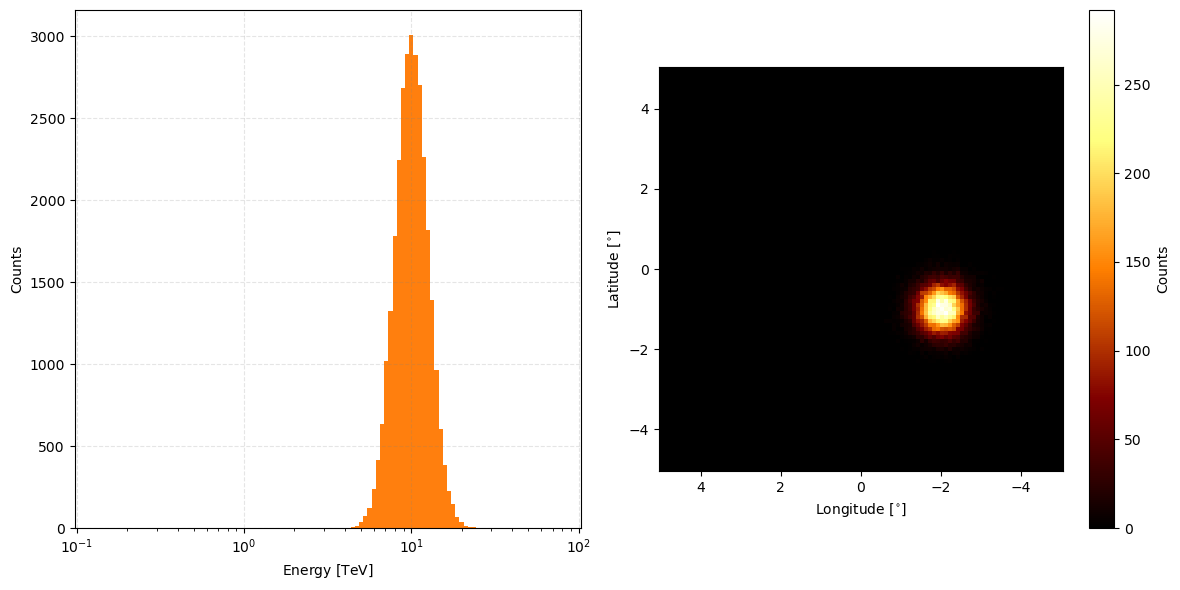

In [14]:
num_events_2 = int(3e4)

energy_data_2 = np.power(10., norm(scale=0.1, loc=1).rvs(size=num_events_2))*u.TeV
lon_data_2 = norm(scale=0.4, loc=-2).rvs(num_events_2)*u.deg
lat_data_2 = norm(scale=0.4, loc=-1.).rvs(num_events_2)*u.deg

observation_data_2 = GammaObs(energy=energy_data_2, lon=lon_data_2, lat=lat_data_2, binning_geometry=binning_geometry, 
                              pointing_dir=pointing, observation_time=0.17*u.hr,
                              irf_loglike=irf_loglike)
observation_data_2.peek(figsize=(12,6))

Then to combine the data from the two sets you can just add them like so.

array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

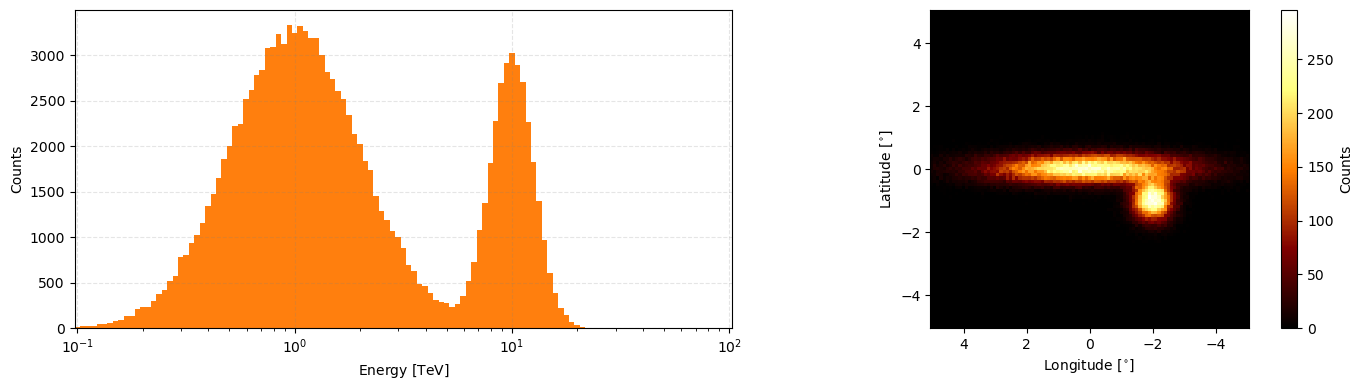

In [15]:
combined_observation_data = observation_data+observation_data_2

combined_observation_data.peek(figsize=(14,4))

And for more so for single observations, one can look at the total exposure for the observation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


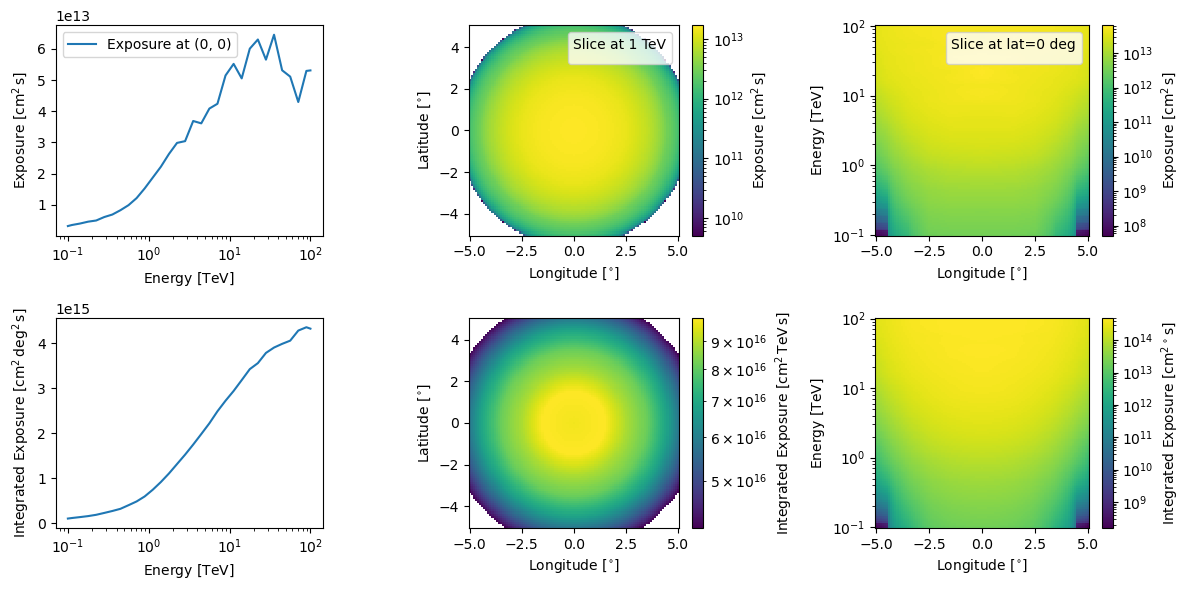

In [16]:
observation_data.log_exposure.peek(figsize=(12,6))
plt.show()

You can also do this for combined exposures but if that is the case we more recommend you use `GammaObsCube` that `GammaObs`.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


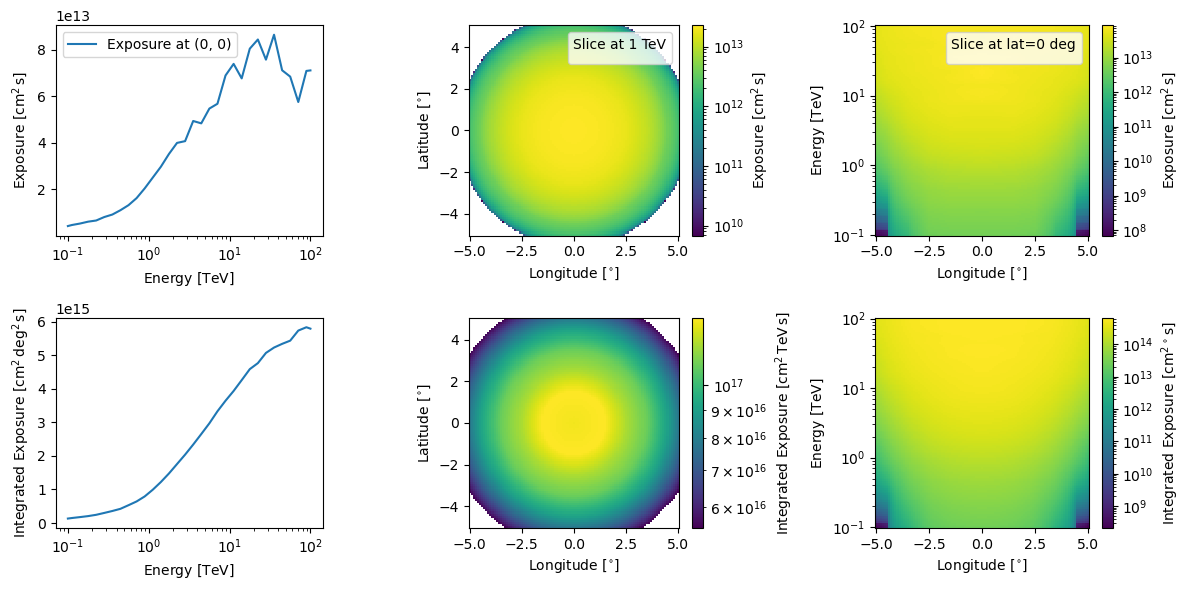

In [17]:
combined_observation_data.log_exposure.peek(figsize=(12,6))
plt.show()

And because the pointing is the same and we presume that if one is combining multiple observations then the IRFs are at least similar, when observations are added it uses whatever the first object's IRFs were.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


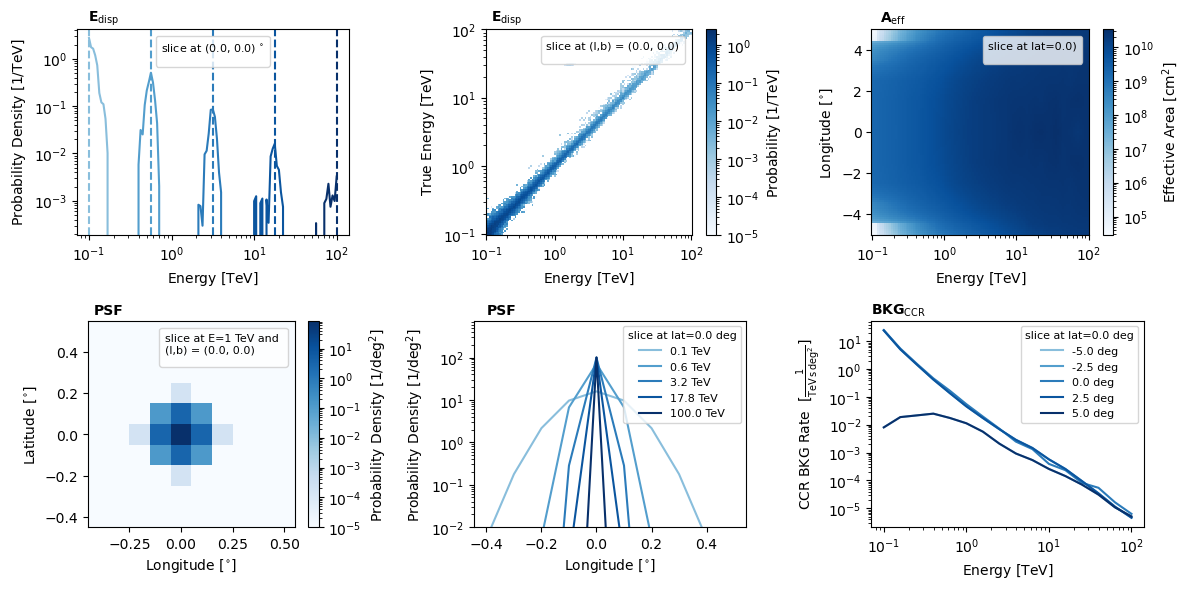

In [18]:
combined_observation_data.irf_loglike.peek()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


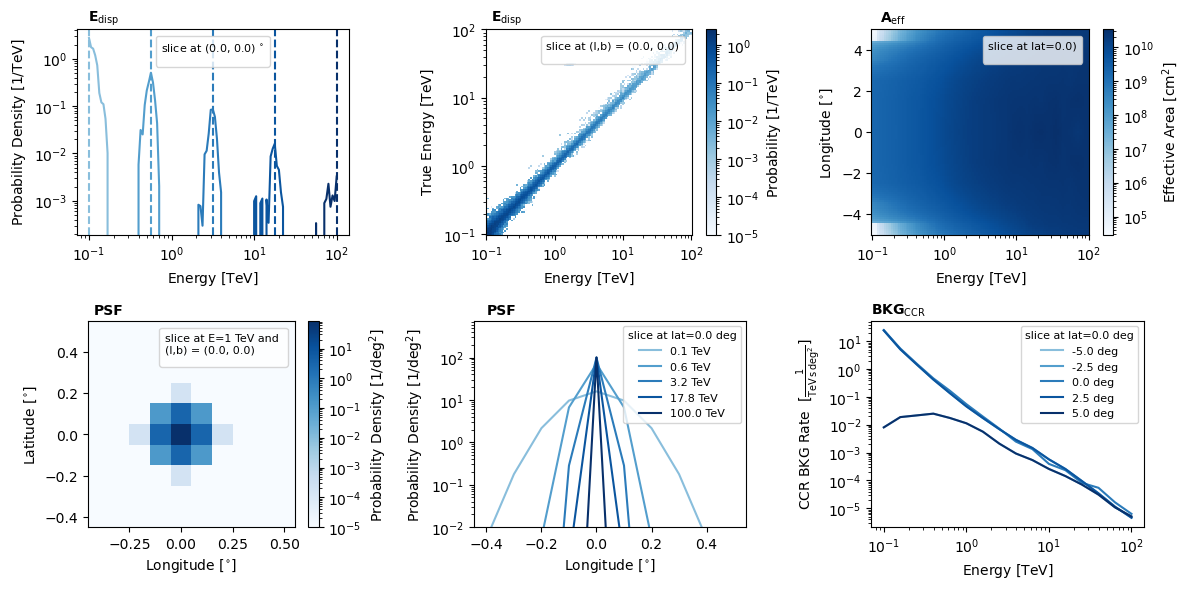

In [19]:
observation_data.irf_loglike.peek()
plt.show()

And finally, you can extract the more important information contained in the class into a generic dictionary using the `to_dict` method.

In [20]:
observation_dict = observation_data.to_dict()

observation_dict['pointing_dir'], observation_dict['binning_geometry']['energy_axis'], observation_dict['binned_data']

(<Quantity [0., 0.] deg>,
 <Quantity [  0.1       ,   0.10592537,   0.11220185,   0.11885022,
              0.12589254,   0.13335214,   0.14125375,   0.14962357,
              0.15848932,   0.1678804 ,   0.17782794,   0.18836491,
              0.19952623,   0.2113489 ,   0.22387211,   0.23713737,
              0.25118864,   0.26607251,   0.28183829,   0.29853826,
              0.31622777,   0.33496544,   0.35481339,   0.3758374 ,
              0.39810717,   0.4216965 ,   0.44668359,   0.47315126,
              0.50118723,   0.53088444,   0.56234133,   0.59566214,
              0.63095734,   0.66834392,   0.70794578,   0.74989421,
              0.79432823,   0.84139514,   0.89125094,   0.94406088,
              1.        ,   1.05925373,   1.12201845,   1.18850223,
              1.25892541,   1.33352143,   1.41253754,   1.49623566,
              1.58489319,   1.67880402,   1.77827941,   1.88364909,
              1.99526231,   2.11348904,   2.23872114,   2.37137371,
              2.511886

## `GammaObsCube`

If you are dealing with multiple sets of observations then we recommend using `GammaObsCube`.

To instantiate the `GammaObsCube` class you need a list of `GammaObs` like below, don't mind the `added_observation` thing for now.

In [21]:
added_observation = False


pointings = [np.array([-2,2])*u.deg,
             np.array([2,2])*u.deg,
             np.array([0,0])*u.deg,
             np.array([-2,-2])*u.deg,
             np.array([2,-2])*u.deg,]

observation_times = [5*u.hr, 5*u.hr, 0.5*u.hr, 5*u.hr, 5*u.hr, ]
num_events = [int(3e4), int(2e4), int(1e4), int(1e4), int(1e4)]


source_coords = [np.array([-1,1.5])*u.deg,
             np.array([1.5,1])*u.deg,
             np.array([0,0])*u.deg,
             np.array([-1.5,-1.5])*u.deg,
             np.array([1,-1])*u.deg,]

energy_dist_vals = [[-0.5, 0.2], [0, 0.2], [0.5, 0.15], [1.0, 0.2], [1.5, 0.25]]

observations = []

for pointing_dir, obs_time, source_coord, num_event, energy_dist in zip(pointings, observation_times, source_coords, num_events, energy_dist_vals):

    irf_loglike_for_obs = IRF_LogLikelihood(pointing_dir=pointing_dir,
                                            observation_time=obs_time,
                                            binning_geometry=binning_geometry,
                                            true_binning_geometry=binning_geometry,)
    

    energy_data_for_obs = np.power(10., norm(scale=energy_dist[1], loc=energy_dist[0]).rvs(size=num_event))*u.TeV
    lon_data_for_obs = norm(scale=0.3, loc=source_coord[0].value).rvs(num_event)*u.deg
    lat_data_for_obs = norm(scale=0.3, loc=source_coord[1].value).rvs(num_event)*u.deg

    observation = GammaObs(energy=energy_data_for_obs,
                           lon=lon_data_for_obs,
                           lat=lat_data_for_obs,
                           binning_geometry=binning_geometry,
                           irf_loglike=irf_loglike_for_obs,
                           pointing_dir=pointing_dir,
                           observation_time=obs_time)
    
    observations.append(observation)
    


Then we can just pass that to `GammaObsCube` and it will take care of the rest. If you don't specify the binning geometry for the observations though it will use whatever the binning geometry is for the first observation in the given list.

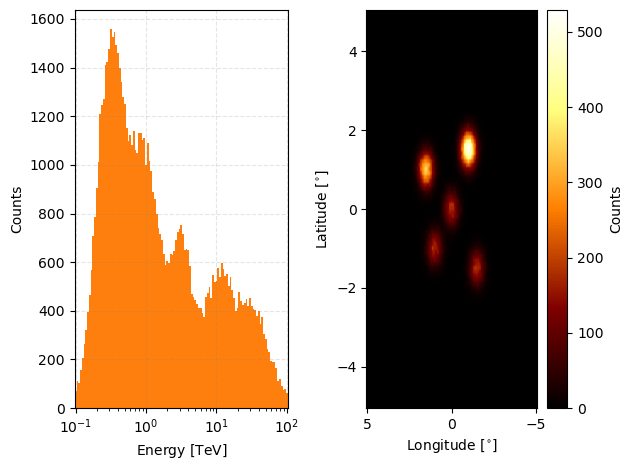

In [22]:
from gammabayes import GammaObsCube

observation_cube = GammaObsCube(observations=observations)

observation_cube.peek()
plt.show()

And then we can look at the combined exposure.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


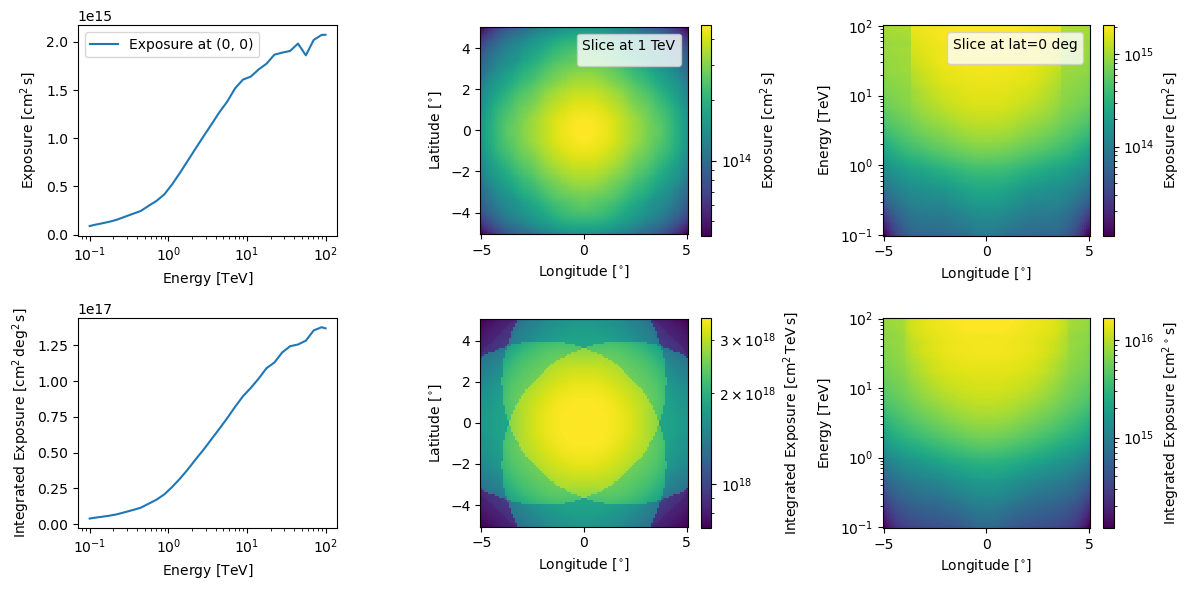

In [23]:
observation_cube.combined_log_exposure.peek(figsize=(12,6))
plt.show()

Or you can access the individual log exposures through the `log_exposures` attribute

In [24]:
observation_cube.log_exposures

You can access the most central pointing direction through the `central_pointing` attribute.

In [25]:
observation_cube.central_pointing

<Quantity [0., 0.] deg>

With various other attributes that you may find handy with hopefully self-explanatory names

In [26]:
observation_cube.lon_pointing_dirs, observation_cube.lat_pointing_dirs, observation_cube.irf_loglikes

([<Quantity -2. deg>,
  <Quantity 2. deg>,
  <Quantity 0. deg>,
  <Quantity -2. deg>,
  <Quantity 2. deg>],
 [<Quantity 2. deg>,
  <Quantity 2. deg>,
  <Quantity 0. deg>,
  <Quantity -2. deg>,
  <Quantity -2. deg>],
 [discrete log likelihood class
  ---------------------------------
  name = ['None']
  logfunction type is <bound method IRFExtractor.single_loglikelihood of <gammabayes.likelihoods.irfs.irf_extractor_class.IRFExtractor object at 0x1b11b16d0>>
  input units of ['None'],
  discrete log likelihood class
  ---------------------------------
  name = ['None']
  logfunction type is <bound method IRFExtractor.single_loglikelihood of <gammabayes.likelihoods.irfs.irf_extractor_class.IRFExtractor object at 0x1b0790fb0>>
  input units of ['None'],
  discrete log likelihood class
  ---------------------------------
  name = ['None']
  logfunction type is <bound method IRFExtractor.single_loglikelihood of <gammabayes.likelihoods.irfs.irf_extractor_class.IRFExtractor object at 0x1aeac82

You can add observations using the `add_observation` method that works similarly to the `append` list method keeping in mind that we don't check observation names here to make test cases less strenuous to make... so if you append the same observation twice then the same information will be added twice... 

(<Figure size 1000x400 with 3 Axes>,
 array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
        <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
       dtype=object))

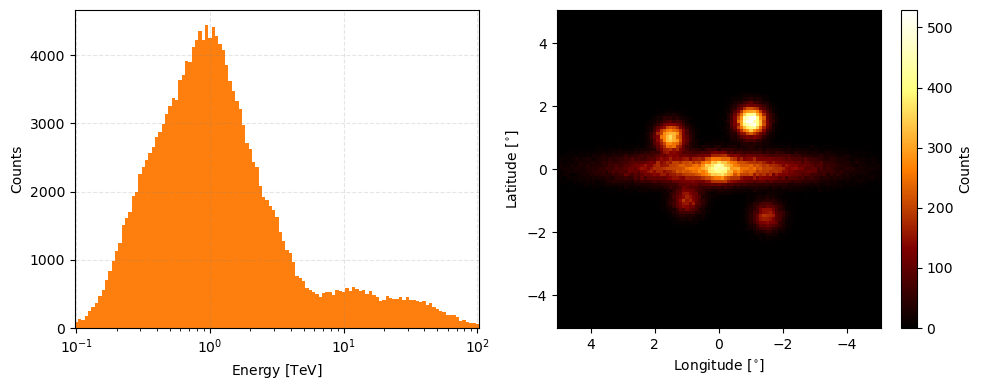

In [27]:

if not added_observation:
    observation_cube.add_observation(observation_data)
    added_observation = True

observation_cube.peek(figsize=(10,4))

You can call the `len` function on it and it will return the number of observations.

In [28]:
len(observation_cube)

6

And the iterative and slicing behaviour for the class is on the list single observations.

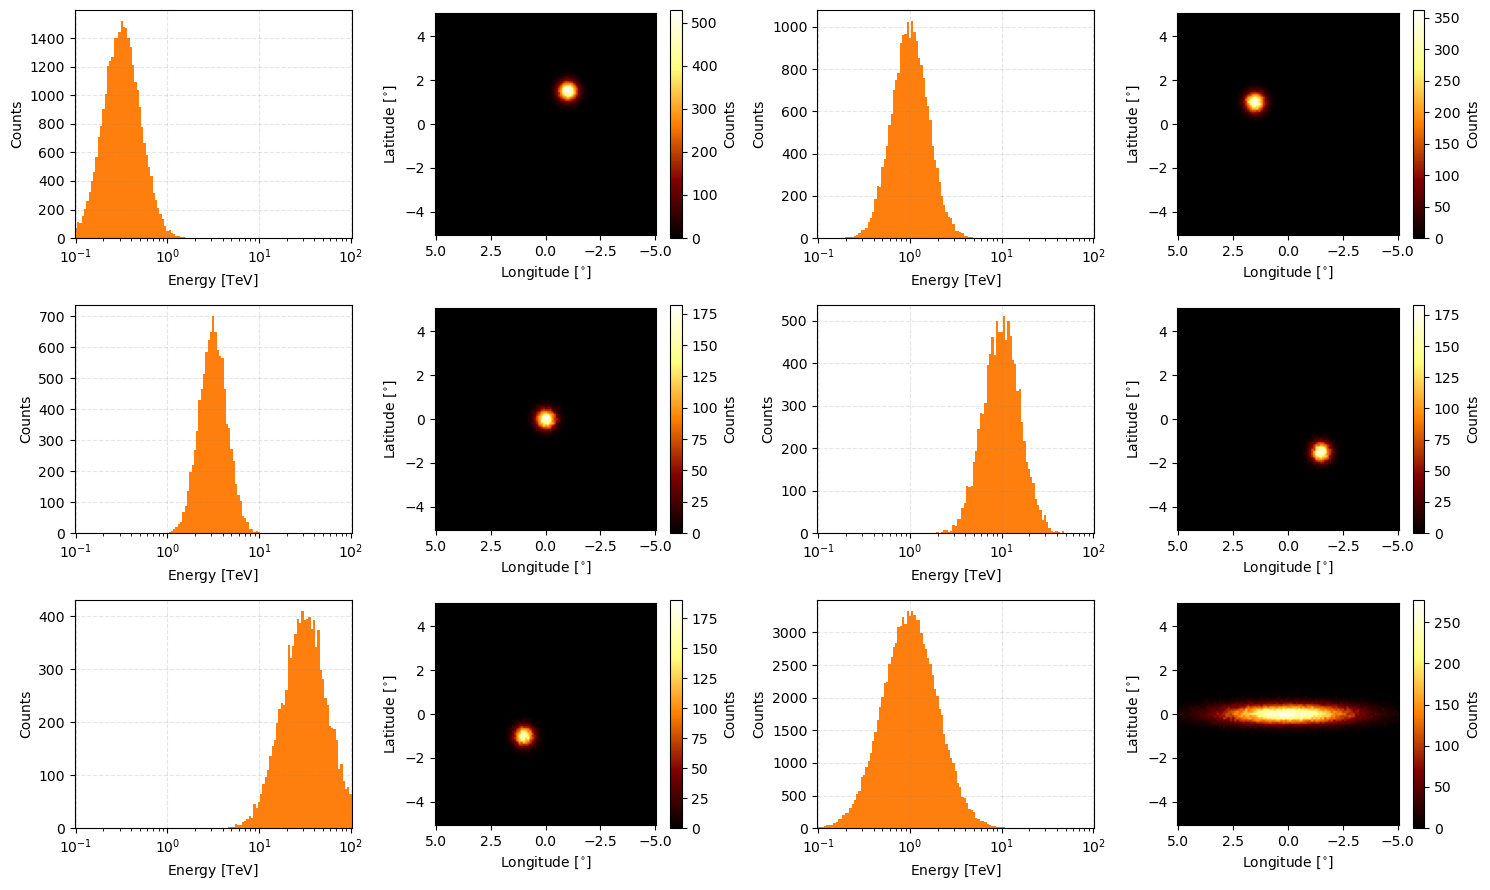

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(15,9))
axs = axs.flatten()

for obs_idx, obs in enumerate(observation_cube):
    obs.peek(axs=axs[obs_idx])
plt.tight_layout()

plt.show()

array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

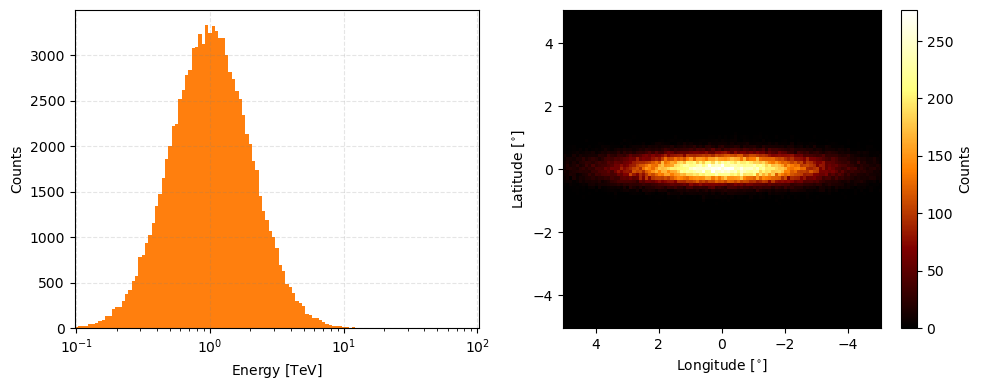

In [34]:
observation_cube[-1].peek(figsize=(10,4))

You can then access the raw binned event counts through the relevant `collapsed` method.

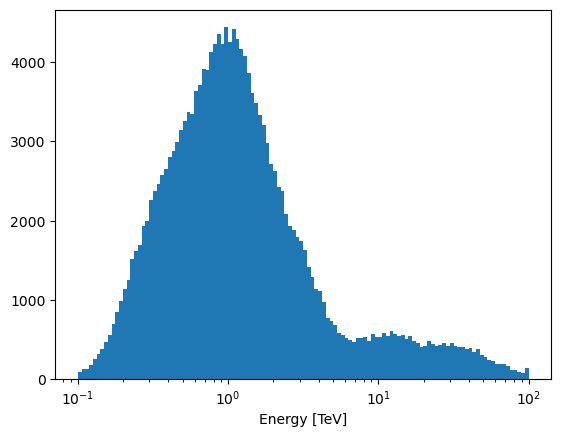

In [31]:
plt.hist(observation_cube.collapsed_energy[1], weights=observation_cube.collapsed_energy[0], bins=observation_cube.collapsed_energy[1],)
plt.xlabel("Energy [TeV]")
plt.xscale('log')
plt.show()

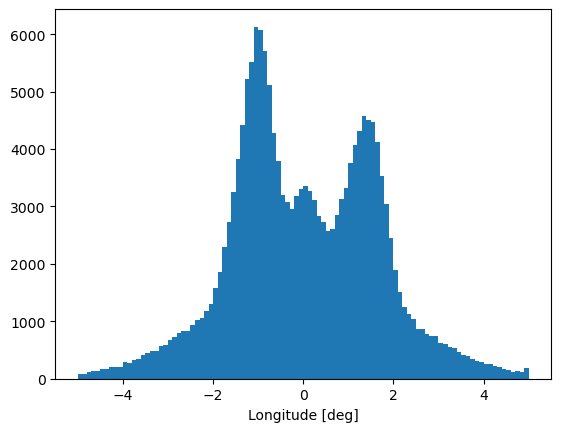

In [32]:
plt.hist(observation_cube.collapsed_lon[1], weights=observation_cube.collapsed_lon[0], bins=observation_cube.collapsed_lon[1],)
plt.xlabel("Longitude [deg]")
plt.show()

With `collapsed_data` giving the combined matrix of bins values and axes in a tuple

In [33]:
observation_cube.collapsed_data[0].shape, [axis.shape for axis in observation_cube.collapsed_data[1]]

((121, 101, 101), [(121,), (101,), (101,)])

Those are the main properties of `GammaObs` and `GammaObsCube`! Next we're going to finally jump into some simulations while learning about the observational prior classes in `GammaBayes`.